In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import numpy as np
import random
import matplotlib.pyplot as plt

model_name = "gpt2"
print(f"Loading {model_name}...")
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.eval()

vocab_size = tokenizer.vocab_size
if hasattr(model.config, 'hidden_size'):
    true_dim = model.config.hidden_size
    print(f"True hidden dimension: {true_dim}")

max_queries = 2048
print(f"\nGenerating {max_queries} unique random prompts...")

random_prompts = set()
while len(random_prompts) < max_queries:
    num_tokens = 1
    token_ids = random.sample(range(vocab_size), num_tokens)
    prompt = tokenizer.decode(token_ids, skip_special_tokens=True).strip()
    if prompt:
        random_prompts.add(prompt)

random_prompts = list(random_prompts)
print(f"Generated {len(random_prompts)} unique prompts")


print("\nCollecting logits from model...")
all_logits = []
all_hidden_states = []
for i, prompt in enumerate(random_prompts):
    if i % 100 == 0:
        print(f"  Query {i}/{len(random_prompts)}")
    
    inputs = tokenizer(prompt, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        final_hidden_state = outputs.hidden_states[-1][0, -1, :].numpy()
        all_hidden_states.append(final_hidden_state)
        # Extract last token logits
        logits = outputs.logits[0, -1, :].numpy()
        all_logits.append(logits)

full_matrix = np.array(all_logits)
print(f"Full logits collected. Shape: {full_matrix.shape}")

Loading gpt2...
True hidden dimension: 768

Generating 2048 unique random prompts...
Generated 2048 unique prompts

  Query 0/2048
  Query 100/2048
  Query 200/2048
  Query 300/2048
  Query 400/2048
  Query 500/2048
  Query 600/2048
  Query 700/2048
  Query 800/2048
  Query 900/2048
  Query 1000/2048
  Query 1100/2048
  Query 1200/2048
  Query 1300/2048
  Query 1400/2048
  Query 1500/2048
  Query 1600/2048
  Query 1700/2048
  Query 1800/2048
  Query 1900/2048
  Query 2000/2048
Full logits collected. Shape: (2048, 50257)



Running SVD and generating plots...
Subset n=512
Subset n=768
Subset n=1024
Subset n=2048

Plot saved as 'hidden_dim_attack_combined_gpt2.png'


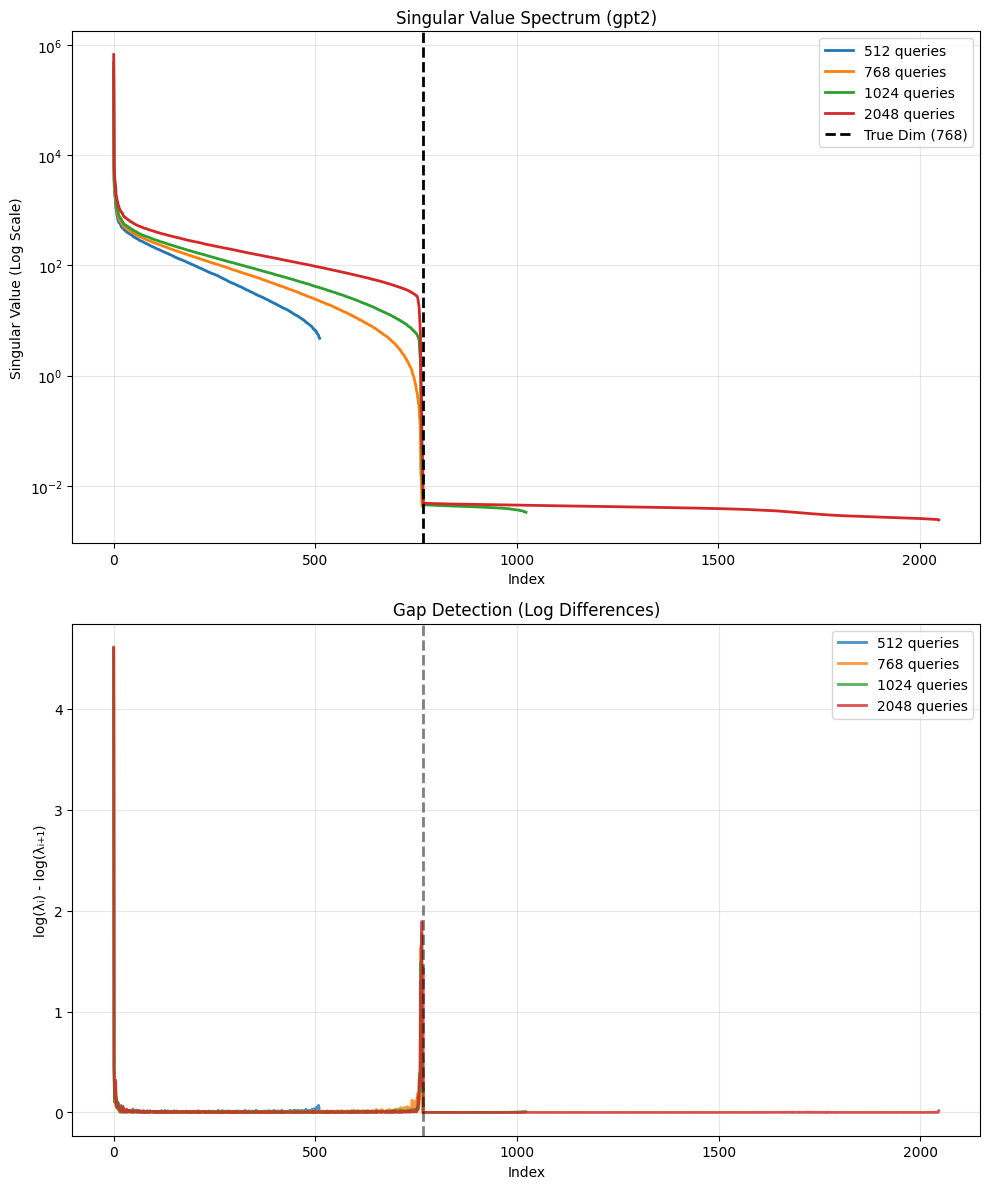

In [9]:

print("\nRunning SVD and generating plots...")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
query_subsets = [512, 768, 1024, 2048]

colors = ['C0', 'C1', 'C2', 'C3']

for n, color in zip(query_subsets, colors):
    print(f"Subset n={n}")
    sub_matrix = full_matrix[:n, :]
    

    S = np.linalg.svd(sub_matrix, full_matrices=False, compute_uv=False)
    
    ax1.plot(S, linewidth=2, label=f'{n} queries', color=color)

    log_diffs = np.log(S[:-1]) - np.log(S[1:])
    
    ax2.plot(log_diffs, linewidth=2, label=f'{n} queries', color=color, alpha=0.8)
    

# -- Formatting Top Plot --
ax1.set_title(f'Singular Value Spectrum ({model_name})')
ax1.set_ylabel('Singular Value (Log Scale)')
ax1.set_xlabel('Index')
ax1.set_yscale('log')
ax1.grid(True, which="both", alpha=0.3)
if hasattr(model.config, 'hidden_size'):
    ax1.axvline(x=true_dim, color='k', linestyle='--', linewidth=2, label=f'True Dim ({true_dim})')
ax1.legend()

# -- Formatting Bottom Plot --
ax2.set_title('Gap Detection (Log Differences)')
ax2.set_ylabel('log(λᵢ) - log(λᵢ₊₁)')
ax2.set_xlabel('Index')
ax2.grid(True, alpha=0.3)
# Add a line for true dimension on the bottom plot as well for reference
if hasattr(model.config, 'hidden_size'):
    ax2.axvline(x=true_dim-1, color='k', linestyle='--', linewidth=2, alpha=0.5)
ax2.legend()

plt.tight_layout()
filename = f'hidden_dim_attack_combined_{model_name}.png'
plt.savefig(filename, dpi=300)
print(f"\nPlot saved as '{filename}'")
plt.show()

## Investigate why its not working

Hidden states shape: (2048, 768)
Number of singular values: 768
Largest singular value: 6388.56
Second Largest singular value: 652.86
Smallest singular value: 7.01e-03

Largest gap occurs at index: 0
This suggests the hidden dimension is: 1
True hidden dimension: 768


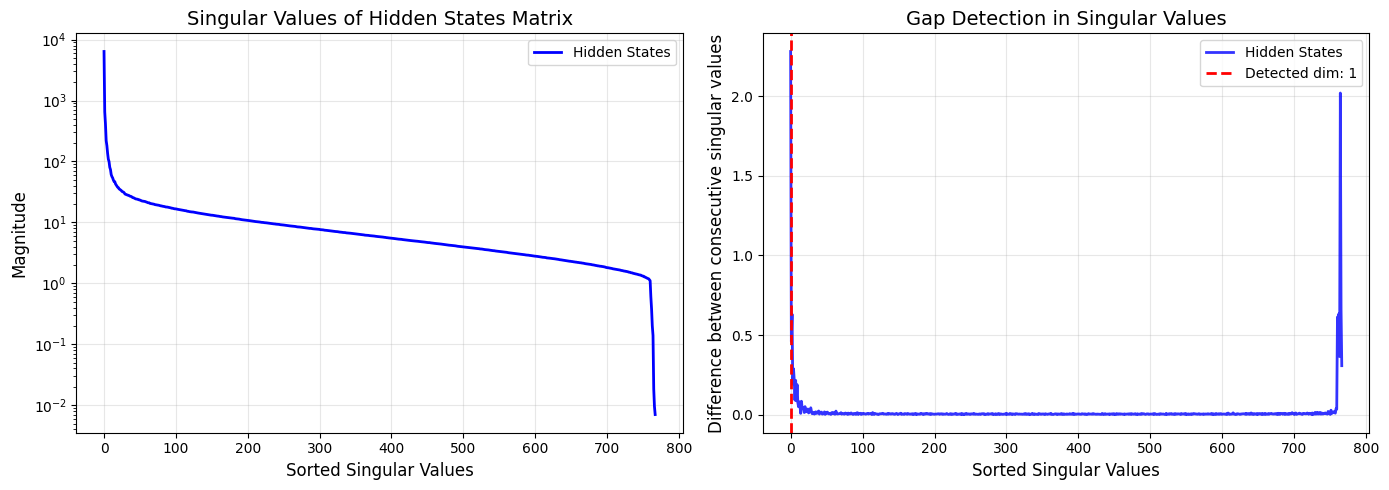


Plot saved as 'hidden_states_svd_analysis.png'


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

full_hidden_states = np.array(all_hidden_states)
print(f"Hidden states shape: {full_hidden_states.shape}") 

S_hidden = np.linalg.svd(full_hidden_states.T, full_matrices=False, compute_uv=False)

print(f"Number of singular values: {len(S_hidden)}")
print(f"Largest singular value: {S_hidden[0]:.2f}")
print(f"Second Largest singular value: {S_hidden[1]:.2f}")
print(f"Smallest singular value: {S_hidden[-1]:.2e}")

# Create the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Singular values
ax1.plot(S_hidden, linewidth=2, color='blue', label='Hidden States')
ax1.set_xlabel('Sorted Singular Values', fontsize=12)
ax1.set_ylabel('Magnitude', fontsize=12)
ax1.set_title('Singular Values of Hidden States Matrix', fontsize=14)
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Differences between consecutive singular values (to find the gap)
log_diffs_hidden = np.log(S_hidden[:-1]) - np.log(S_hidden[1:])
ax2.plot(log_diffs_hidden, linewidth=2, color='blue', alpha=0.8, label='Hidden States')
ax2.set_xlabel('Sorted Singular Values', fontsize=12)
ax2.set_ylabel('Difference between consecutive singular values', fontsize=12)
ax2.set_title('Gap Detection in Singular Values', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend()

# Find the largest gap (this should occur around the true hidden dimension)
max_gap_idx = np.argmax(log_diffs_hidden)
print(f"\nLargest gap occurs at index: {max_gap_idx}")
print(f"This suggests the hidden dimension is: {max_gap_idx + 1}")
print(f"True hidden dimension: {true_dim}")

# Add a vertical line at the detected dimension
ax2.axvline(x=max_gap_idx, color='red', linestyle='--', 
            linewidth=2, label=f'Detected dim: {max_gap_idx + 1}')
ax2.legend()

plt.tight_layout()
plt.savefig('hidden_states_svd_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPlot saved as 'hidden_states_svd_analysis.png'")


Generating 2048 unique random prompts with longer length ...
  Query 0/2048
  Query 100/2048
  Query 200/2048
  Query 300/2048
  Query 400/2048
  Query 500/2048
  Query 600/2048
  Query 700/2048
  Query 800/2048
  Query 900/2048
  Query 1000/2048
  Query 1100/2048
  Query 1200/2048
  Query 1300/2048
  Query 1400/2048
  Query 1500/2048
  Query 1600/2048
  Query 1700/2048
  Query 1800/2048
  Query 1900/2048
  Query 2000/2048
Subset n=512
Subset n=768
Subset n=1024
Subset n=2048

Plot saved as 'hidden_dim_attack_combined_gpt2.png'


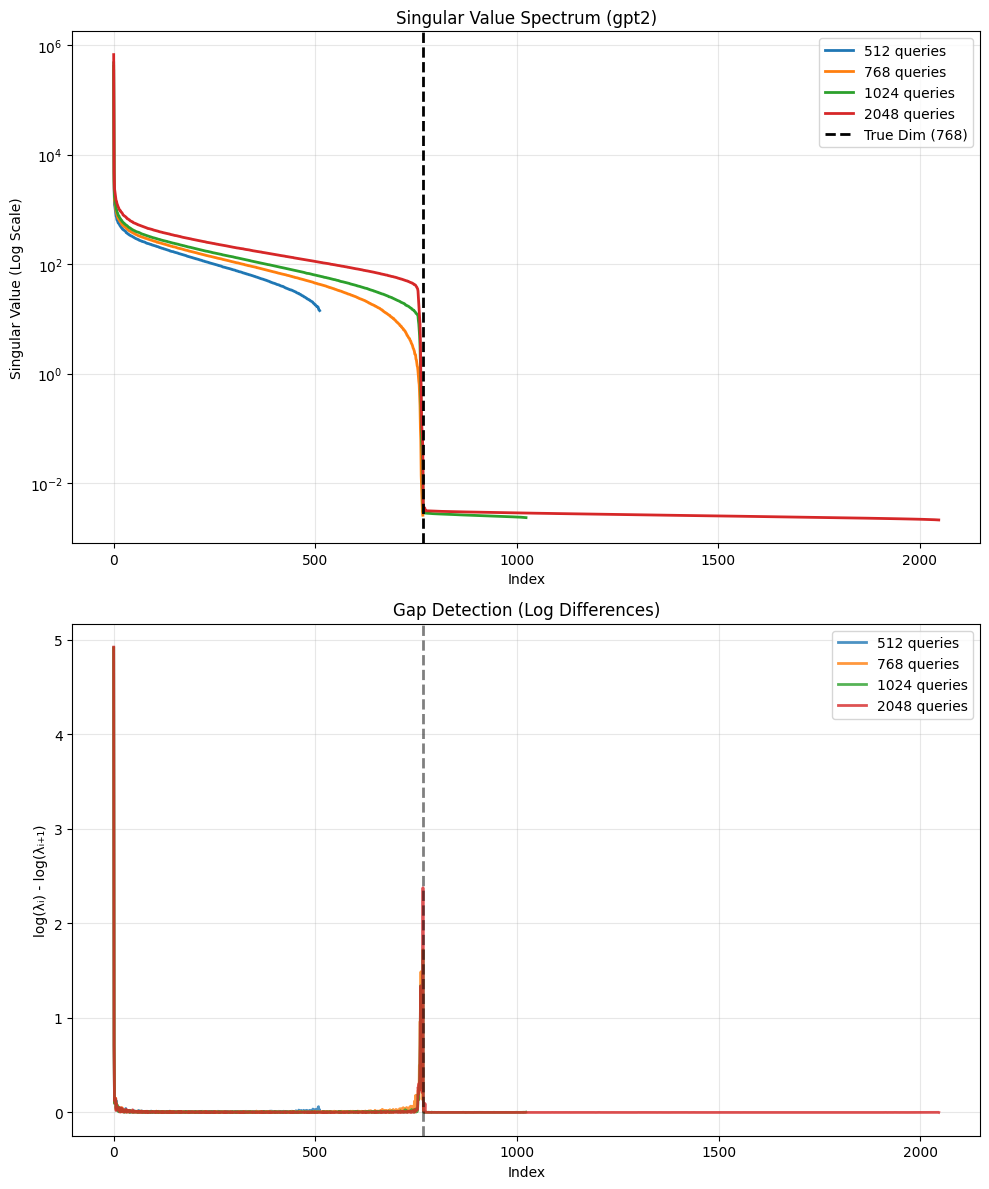

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import numpy as np
import random
import matplotlib.pyplot as plt

model_name = "gpt2"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.eval()

vocab_size = tokenizer.vocab_size
if hasattr(model.config, 'hidden_size'):
    true_dim = model.config.hidden_size

max_queries = 2048
print(f"\nGenerating {max_queries} unique random prompts with longer length ...")

random_prompts = set()
while len(random_prompts) < max_queries:
    num_tokens = 128
    token_ids = random.sample(range(vocab_size), num_tokens)
    prompt = tokenizer.decode(token_ids, skip_special_tokens=True).strip()
    if prompt:
        random_prompts.add(prompt)

random_prompts = list(random_prompts)


all_logits = []
all_hidden_states = []
for i, prompt in enumerate(random_prompts):
    if i % 100 == 0:
        print(f"  Query {i}/{len(random_prompts)}")
    
    inputs = tokenizer(prompt, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        final_hidden_state = outputs.hidden_states[-1][0, -1, :].numpy()
        all_hidden_states.append(final_hidden_state)
        # Extract last token logits
        logits = outputs.logits[0, -1, :].numpy()
        all_logits.append(logits)

full_matrix = np.array(all_logits)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
query_subsets = [512, 768, 1024, 2048]

colors = ['C0', 'C1', 'C2', 'C3']

for n, color in zip(query_subsets, colors):
    print(f"Subset n={n}")
    sub_matrix = full_matrix[:n, :]
    

    S = np.linalg.svd(sub_matrix, full_matrices=False, compute_uv=False)
    
    ax1.plot(S, linewidth=2, label=f'{n} queries', color=color)

    log_diffs = np.log(S[:-1]) - np.log(S[1:])
    
    ax2.plot(log_diffs, linewidth=2, label=f'{n} queries', color=color, alpha=0.8)
    

ax1.set_title(f'Singular Value Spectrum ({model_name})')
ax1.set_ylabel('Singular Value (Log Scale)')
ax1.set_xlabel('Index')
ax1.set_yscale('log')
ax1.grid(True, which="both", alpha=0.3)
if hasattr(model.config, 'hidden_size'):
    ax1.axvline(x=true_dim, color='k', linestyle='--', linewidth=2, label=f'True Dim ({true_dim})')
ax1.legend()


ax2.set_title('Gap Detection (Log Differences)')
ax2.set_ylabel('log(λᵢ) - log(λᵢ₊₁)')
ax2.set_xlabel('Index')
ax2.grid(True, alpha=0.3)
if hasattr(model.config, 'hidden_size'):
    ax2.axvline(x=true_dim-1, color='k', linestyle='--', linewidth=2, alpha=0.5)
ax2.legend()

plt.tight_layout()
filename = f'hidden_dim_attack_combined_{model_name}.png'
plt.savefig(filename, dpi=300)
print(f"\nPlot saved as '{filename}'")
plt.show()


Generating 2048 unique random prompts with longer length ...
  Query 0/2048
  Query 100/2048
  Query 200/2048
  Query 300/2048
  Query 400/2048
  Query 500/2048
  Query 600/2048
  Query 700/2048
  Query 800/2048
  Query 900/2048
  Query 1000/2048
  Query 1100/2048
  Query 1200/2048
  Query 1300/2048
  Query 1400/2048
  Query 1500/2048
  Query 1600/2048
  Query 1700/2048
  Query 1800/2048
  Query 1900/2048
  Query 2000/2048
Subset n=512
Subset n=768
Subset n=1024
Subset n=2048

Plot saved as 'hidden_dim_attack_combined_pythia.png'


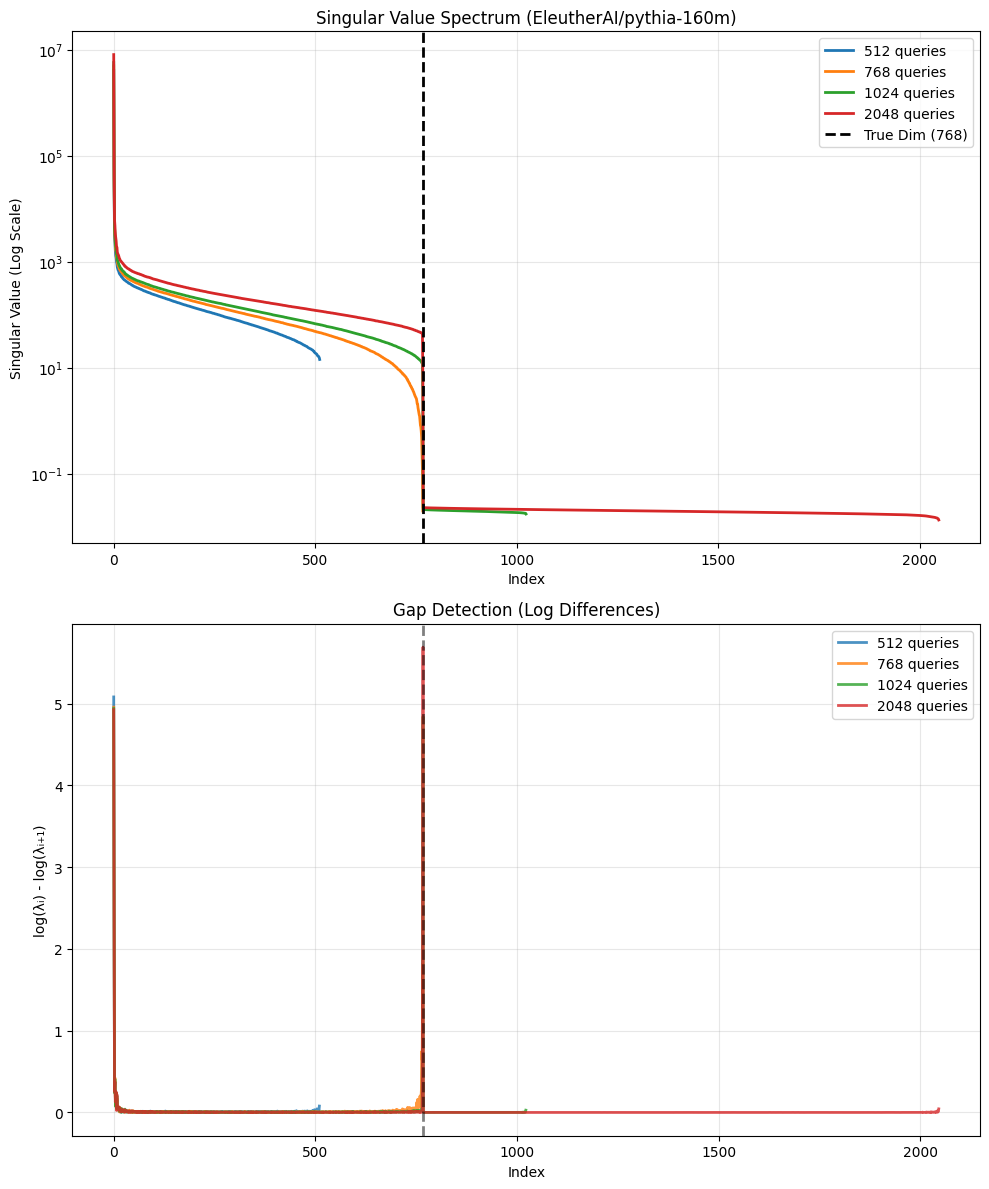

In [16]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import numpy as np
import random
import matplotlib.pyplot as plt

model_name = "EleutherAI/pythia-160m"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.eval()

vocab_size = tokenizer.vocab_size
if hasattr(model.config, 'hidden_size'):
    true_dim = model.config.hidden_size

max_queries = 2048
print(f"\nGenerating {max_queries} unique random prompts with longer length ...")

random_prompts = set()
while len(random_prompts) < max_queries:
    num_tokens = 128
    token_ids = random.sample(range(vocab_size), num_tokens)
    prompt = tokenizer.decode(token_ids, skip_special_tokens=True).strip()
    if prompt:
        random_prompts.add(prompt)

random_prompts = list(random_prompts)


all_logits = []
all_hidden_states = []
for i, prompt in enumerate(random_prompts):
    if i % 100 == 0:
        print(f"  Query {i}/{len(random_prompts)}")
    
    inputs = tokenizer(prompt, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        final_hidden_state = outputs.hidden_states[-1][0, -1, :].numpy()
        all_hidden_states.append(final_hidden_state)
        # Extract last token logits
        logits = outputs.logits[0, -1, :].numpy()
        all_logits.append(logits)

full_matrix = np.array(all_logits)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
query_subsets = [512, 768, 1024, 2048]

colors = ['C0', 'C1', 'C2', 'C3']

for n, color in zip(query_subsets, colors):
    print(f"Subset n={n}")
    sub_matrix = full_matrix[:n, :]
    

    S = np.linalg.svd(sub_matrix, full_matrices=False, compute_uv=False)
    
    ax1.plot(S, linewidth=2, label=f'{n} queries', color=color)

    log_diffs = np.log(S[:-1]) - np.log(S[1:])
    
    ax2.plot(log_diffs, linewidth=2, label=f'{n} queries', color=color, alpha=0.8)
    

ax1.set_title(f'Singular Value Spectrum ({model_name})')
ax1.set_ylabel('Singular Value (Log Scale)')
ax1.set_xlabel('Index')
ax1.set_yscale('log')
ax1.grid(True, which="both", alpha=0.3)
if hasattr(model.config, 'hidden_size'):
    ax1.axvline(x=true_dim, color='k', linestyle='--', linewidth=2, label=f'True Dim ({true_dim})')
ax1.legend()


ax2.set_title('Gap Detection (Log Differences)')
ax2.set_ylabel('log(λᵢ) - log(λᵢ₊₁)')
ax2.set_xlabel('Index')
ax2.grid(True, alpha=0.3)
if hasattr(model.config, 'hidden_size'):
    ax2.axvline(x=true_dim-1, color='k', linestyle='--', linewidth=2, alpha=0.5)
ax2.legend()

plt.tight_layout()
filename = f'hidden_dim_attack_combined_{"pythia"}.png'
plt.savefig(filename, dpi=300)
print(f"\nPlot saved as '{filename}'")
plt.show()

Subset n=1024
0


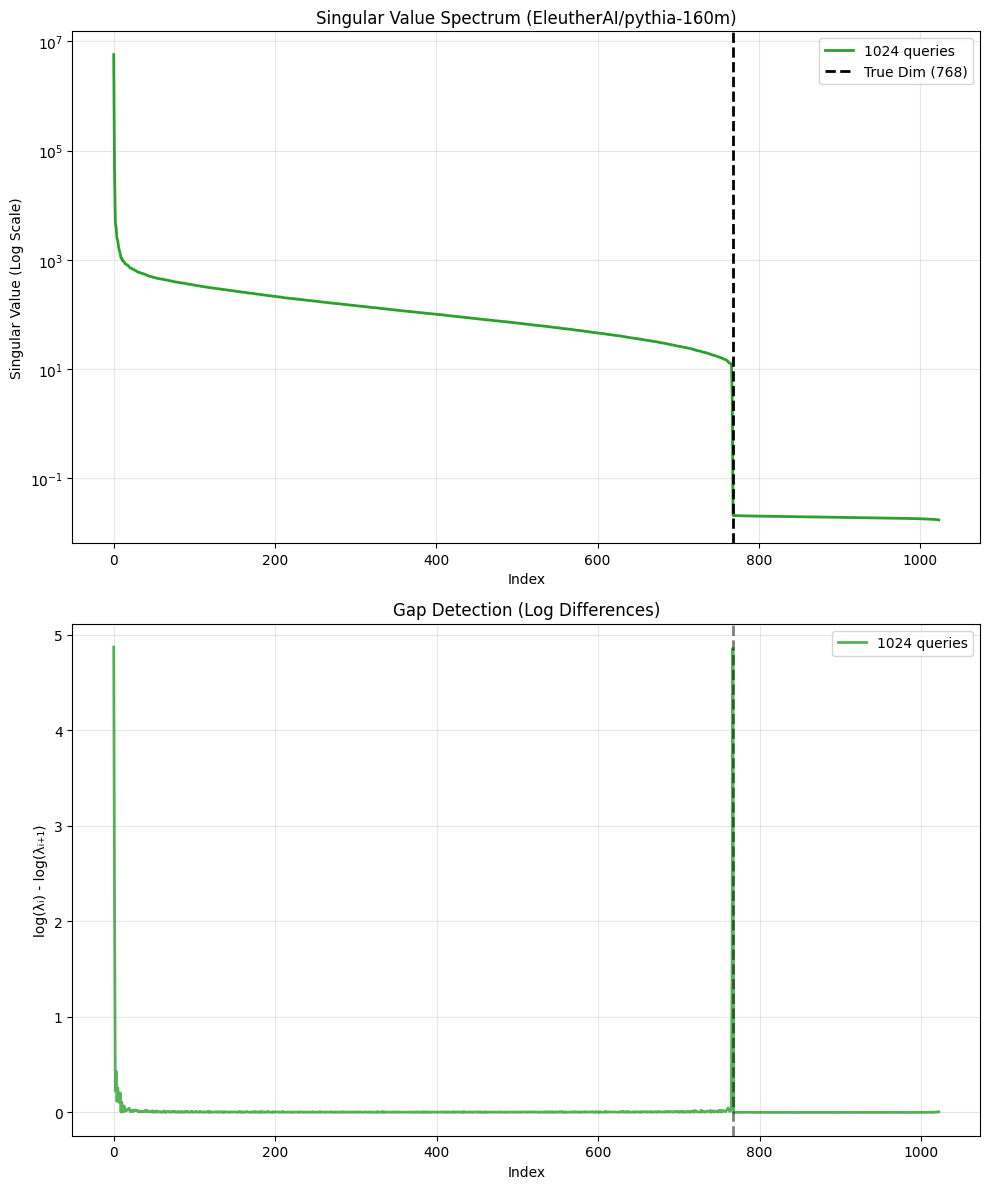

In [ ]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
query_subsets = [1024]

colors = ['C2']

for n, color in zip(query_subsets, colors):
    print(f"Subset n={n}")
    sub_matrix = full_matrix[:n, :]
    

    S = np.linalg.svd(sub_matrix, full_matrices=False, compute_uv=False)
    
    ax1.plot(S, linewidth=2, label=f'{n} queries', color=color)

    log_diffs = np.log(S[:-1]) - np.log(S[1:])
    ax2.plot(log_diffs, linewidth=2, label=f'{n} queries', color=color, alpha=0.8)
    

ax1.set_title(f'Singular Value Spectrum ({model_name})')
ax1.set_ylabel('Singular Value (Log Scale)')
ax1.set_xlabel('Index')
ax1.set_yscale('log')
ax1.grid(True, which="both", alpha=0.3)
if hasattr(model.config, 'hidden_size'):
    ax1.axvline(x=true_dim, color='k', linestyle='--', linewidth=2, label=f'True Dim ({true_dim})')
ax1.legend()


ax2.set_title('Gap Detection (Log Differences)')
ax2.set_ylabel('log(λᵢ) - log(λᵢ₊₁)')
ax2.set_xlabel('Index')
ax2.grid(True, alpha=0.3)
if hasattr(model.config, 'hidden_size'):
    ax2.axvline(x=true_dim-1, color='k', linestyle='--', linewidth=2, alpha=0.5)
ax2.legend()

plt.tight_layout()
plt.show()


Generating 4096 unique random prompts with longer length ...
  Query 0/4096
  Query 100/4096
  Query 200/4096
  Query 300/4096
  Query 400/4096
  Query 500/4096
  Query 600/4096
  Query 700/4096
  Query 800/4096
  Query 900/4096
  Query 1000/4096
  Query 1100/4096
  Query 1200/4096
  Query 1300/4096
  Query 1400/4096
  Query 1500/4096
  Query 1600/4096
  Query 1700/4096
  Query 1800/4096
  Query 1900/4096
  Query 2000/4096
  Query 2100/4096
  Query 2200/4096
  Query 2300/4096
  Query 2400/4096
  Query 2500/4096
  Query 2600/4096
  Query 2700/4096
  Query 2800/4096
  Query 2900/4096
  Query 3000/4096
  Query 3100/4096
  Query 3200/4096
  Query 3300/4096
  Query 3400/4096
  Query 3500/4096
  Query 3600/4096
  Query 3700/4096
  Query 3800/4096
  Query 3900/4096
  Query 4000/4096
Subset n=4096

Plot saved as 'hidden_dim_attack_combined_pythia_4096_64token.png'


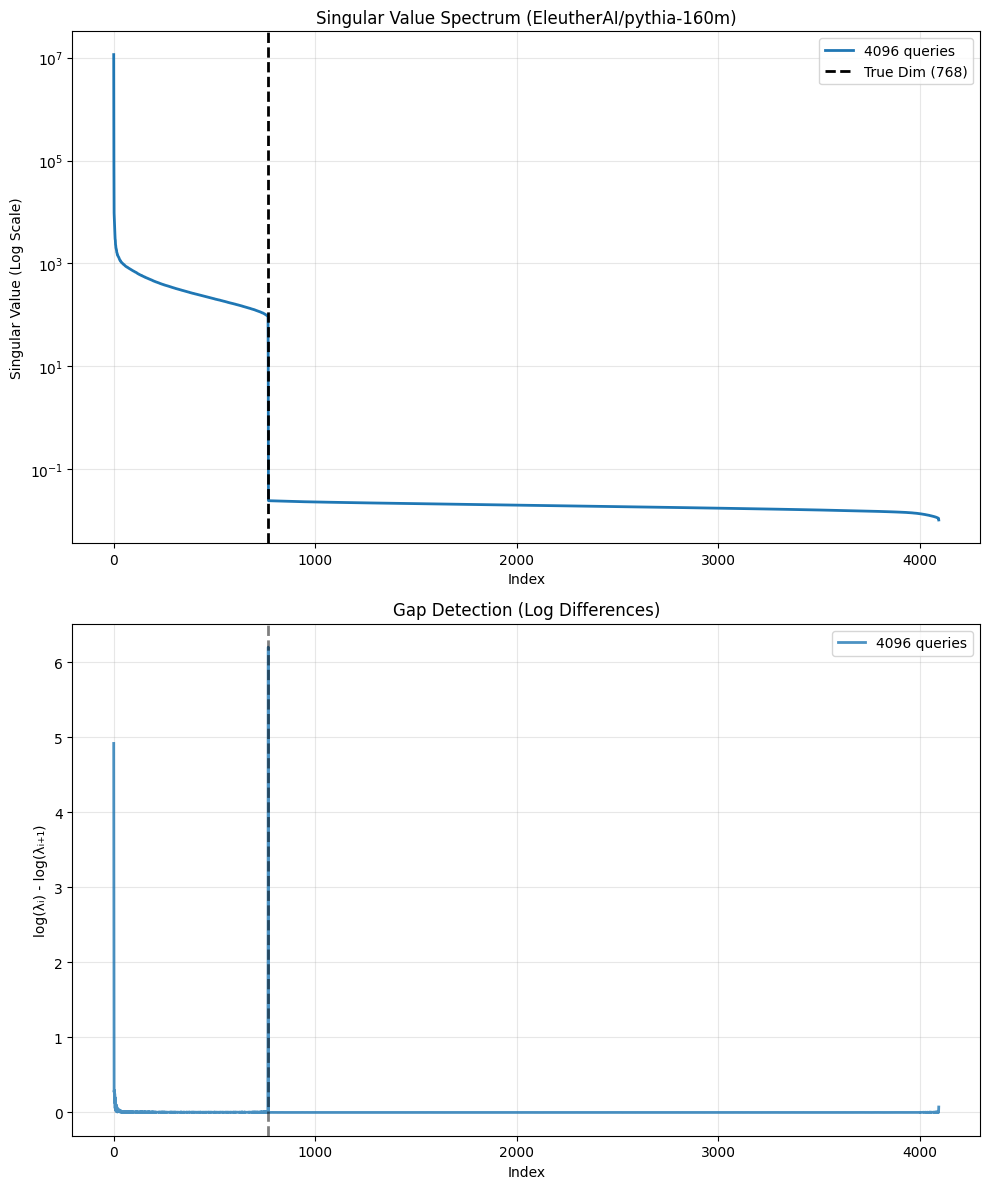

In [19]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import numpy as np
import random
import matplotlib.pyplot as plt

model_name = "EleutherAI/pythia-160m"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.eval()

vocab_size = tokenizer.vocab_size
if hasattr(model.config, 'hidden_size'):
    true_dim = model.config.hidden_size

max_queries = 4096
print(f"\nGenerating {max_queries} unique random prompts with longer length ...")

random_prompts = set()
while len(random_prompts) < max_queries:
    num_tokens = 64
    token_ids = random.sample(range(vocab_size), num_tokens)
    prompt = tokenizer.decode(token_ids, skip_special_tokens=True).strip()
    if prompt:
        random_prompts.add(prompt)

random_prompts = list(random_prompts)


all_logits = []
all_hidden_states = []
for i, prompt in enumerate(random_prompts):
    if i % 100 == 0:
        print(f"  Query {i}/{len(random_prompts)}")
    
    inputs = tokenizer(prompt, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        final_hidden_state = outputs.hidden_states[-1][0, -1, :].numpy()
        all_hidden_states.append(final_hidden_state)
        # Extract last token logits
        logits = outputs.logits[0, -1, :].numpy()
        all_logits.append(logits)

full_matrix = np.array(all_logits)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
query_subsets = [4096]

colors = ['C0']

for n, color in zip(query_subsets, colors):
    print(f"Subset n={n}")
    sub_matrix = full_matrix[:n, :]
    

    S = np.linalg.svd(sub_matrix, full_matrices=False, compute_uv=False)
    
    ax1.plot(S, linewidth=2, label=f'{n} queries', color=color)

    log_diffs = np.log(S[:-1]) - np.log(S[1:])
    
    ax2.plot(log_diffs, linewidth=2, label=f'{n} queries', color=color, alpha=0.8)
    

ax1.set_title(f'Singular Value Spectrum ({model_name})')
ax1.set_ylabel('Singular Value (Log Scale)')
ax1.set_xlabel('Index')
ax1.set_yscale('log')
ax1.grid(True, which="both", alpha=0.3)
if hasattr(model.config, 'hidden_size'):
    ax1.axvline(x=true_dim, color='k', linestyle='--', linewidth=2, label=f'True Dim ({true_dim})')
ax1.legend()


ax2.set_title('Gap Detection (Log Differences)')
ax2.set_ylabel('log(λᵢ) - log(λᵢ₊₁)')
ax2.set_xlabel('Index')
ax2.grid(True, alpha=0.3)
if hasattr(model.config, 'hidden_size'):
    ax2.axvline(x=true_dim-1, color='k', linestyle='--', linewidth=2, alpha=0.5)
ax2.legend()

plt.tight_layout()
filename = f'hidden_dim_attack_combined_{"pythia"}_4096_64token.png'
plt.savefig(filename, dpi=300)
print(f"\nPlot saved as '{filename}'")
plt.show()

Loading EleutherAI/pythia-160m...
True hidden dimension: 768

Loading IMDB dataset (for more natural text)...


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]


Extracting 4096 fixed-length text prefixes (len=64)...
Scanning 25000 documents for valid chunks...
Generated 4096 unique prompts

Sample prompts (First 64 tokens of reviews):
  1. 'This is, without a doubt, the most offensive "chick flick" I have seen in years, if not ever. The writing & characterizations are so riddled with stereotypes that the film verges on parody. Before walking out of the theater an hour and five minutes into this disaster, we were subjected...'
  2. 'Film critics of the world, I apologize. It is your job to give advice to the moviegoing public so that they can wisely choose what to spend money on. But I ignored your advice and I have been deeply hurt. However, my decision to see "The Cat in the Hat" wasn't made haphazard...'
  3. 'There is no artistic value in this movie to deserve any award. Well, it does not deserve an audience as well. Ironically, one of the awards is for cinematography but frankly, the camera movements are disconcerting to say the least. Ev

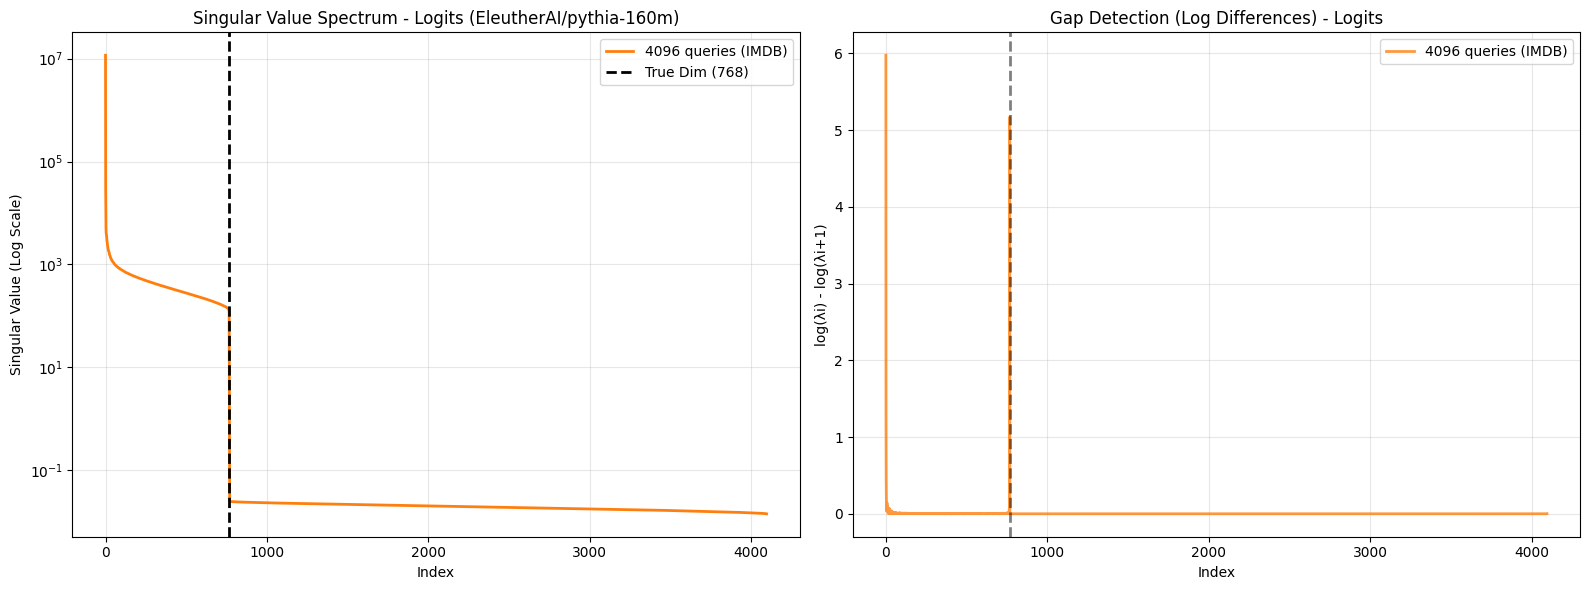

In [27]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import torch
import numpy as np
import random
import matplotlib.pyplot as plt

def extract_fixed_text_chunks(dataset, tokenizer, num_prompts, 
                               chunk_size=64, 
                               max_document_tokens=512): # Increased max limit for reviews
    text_chunks = set()
    all_documents = dataset['train']['text']
    
    # Filter out empty documents
    valid_documents = [doc for doc in all_documents if doc and len(doc.strip()) > 0]
    
    print(f"Scanning {len(valid_documents)} documents for valid chunks...")
    
    while len(text_chunks) < num_prompts:
        # Pick a random document
        document = random.choice(valid_documents)
        
        # BASIC CLEANING: Remove HTML breaks common in IMDB to make prompts "normal"
        document = document.replace("<br />", " ").replace("<br>", " ")
        
        # Convert text to tokens (subword units)
        document_tokens = tokenizer.encode(document, add_special_tokens=False)
        num_tokens_in_doc = len(document_tokens)
        
        # Skip documents that are too short (must be at least the fixed chunk size)
        if num_tokens_in_doc < chunk_size:
            continue
        
        # Ignore extremely long docs just to keep processing fast (optional)
        if num_tokens_in_doc > max_document_tokens:
            continue
        
        # FIXED: Always start from the beginning
        start_position = 0
        
        # FIXED: Always use the exact chunk_size
        chunk_tokens = document_tokens[start_position : start_position + chunk_size]
        
        # Convert tokens back to text
        chunk_text = tokenizer.decode(chunk_tokens, skip_special_tokens=True).strip()
        
        if chunk_text:
            text_chunks.add(chunk_text)
            
    return list(text_chunks)

# Load model
model_name = "EleutherAI/pythia-160m"
print(f"Loading {model_name}...")
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.eval()

true_dim = model.config.hidden_size
print(f"True hidden dimension: {true_dim}")

# Load dataset (IMDB = Normal human-written movie reviews)
print("\nLoading IMDB dataset (for more natural text)...")
dataset = load_dataset("imdb")

# Generate prompts from real text
max_queries = 4096
fixed_chunk_len = 64  # Fixed length for all prompts

print(f"\nExtracting {max_queries} fixed-length text prefixes (len={fixed_chunk_len})...")
random_prompts = extract_fixed_text_chunks(
    dataset, 
    tokenizer, 
    max_queries,
    chunk_size=fixed_chunk_len
)

print(f"Generated {len(random_prompts)} unique prompts")
print(f"\nSample prompts (First 64 tokens of reviews):")
for i, prompt in enumerate(random_prompts[:3]):
    print(f"  {i+1}. '{prompt}...'")

# Collect logits and hidden states
print("\nCollecting logits and hidden states...")
all_logits = []
all_hidden_states = []

for i, prompt in enumerate(random_prompts):
    if i % 500 == 0:
        print(f"  Query {i}/{len(random_prompts)}")
    
    inputs = tokenizer(prompt, return_tensors="pt")
    
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        
        # Last token logits
        logits = outputs.logits[0, -1, :].numpy()
        all_logits.append(logits)
        
        # Last token hidden state
        hidden_state = outputs.hidden_states[-1][0, -1, :].numpy()
        all_hidden_states.append(hidden_state)

full_hidden_states = np.array(all_hidden_states)
full_logits = np.array(all_logits)

print(f"\nHidden states shape: {full_hidden_states.shape}")
print(f"Logits shape: {full_logits.shape}")

# Analyze with SVD
# We transpose to (Features x Samples) for calculation consistency
S_hidden = np.linalg.svd(full_hidden_states.T, full_matrices=False, compute_uv=False)
S_logits = np.linalg.svd(full_logits.T, full_matrices=False, compute_uv=False)

log_diffs_hidden = np.log(S_hidden[:-1]) - np.log(S_hidden[1:])
log_diffs_logits = np.log(S_logits[:-1]) - np.log(S_logits[1:])

detected_dim_hidden = np.argmax(log_diffs_hidden) + 1
detected_dim_logits = np.argmax(log_diffs_logits) + 1

print(f"\nResults:")
print(f"  Detected dimension (hidden states): {detected_dim_hidden}")
print(f"  Detected dimension (logits): {detected_dim_logits}")
print(f"  True dimension: {true_dim}")

# Define query subsets to visualize
query_subsets = [4096]
colors = ['C1'] # Changed color to Orange for difference

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot for different query subset sizes
for n, color in zip(query_subsets, colors):
    if n <= len(full_logits):
        print(f"Subset n={n}")
        sub_matrix = full_logits[:n, :]
        
        S = np.linalg.svd(sub_matrix, full_matrices=False, compute_uv=False)
        
        ax1.plot(S, linewidth=2, label=f'{n} queries (IMDB)', color=color)
        
        log_diffs = np.log(S[:-1]) - np.log(S[1:])
        ax2.plot(log_diffs, linewidth=2, label=f'{n} queries (IMDB)', color=color, alpha=0.8)

ax1.set_title(f'Singular Value Spectrum - Logits ({model_name})')
ax1.set_ylabel('Singular Value (Log Scale)')
ax1.set_xlabel('Index')
ax1.set_yscale('log')
ax1.grid(True, which="both", alpha=0.3)
if hasattr(model.config, 'hidden_size'):
    ax1.axvline(x=true_dim, color='k', linestyle='--', linewidth=2, label=f'True Dim ({true_dim})')
ax1.legend()

ax2.set_title('Gap Detection (Log Differences) - Logits')
ax2.set_ylabel('log(λi) - log(λi+1)')
ax2.set_xlabel('Index')
ax2.grid(True, alpha=0.3)
if hasattr(model.config, 'hidden_size'):
    ax2.axvline(x=true_dim-1, color='k', linestyle='--', linewidth=2, alpha=0.5)
ax2.legend()

plt.tight_layout()
filename = f'hidden_dim_attack_logits_pythia_imdb.png'
plt.savefig(filename, dpi=300)
print(f"\nPlot saved as '{filename}'")
plt.show()

In [28]:
print(full_matrix.shape)

(4096, 50304)


## Full Layer Extraction

In [ ]:
print("FULL LAYER EXTRACTION ATTACK")

print("Performing full SVD to recover singular vectors...")
U, S, Vh = np.linalg.svd(full_matrix, full_matrices=False)

W_rec = Vh[:true_dim, :].T @ np.diag(S[:true_dim])
print(f"Reconstructed W shape: {W_rec.shape}")


W_true = model.lm_head.weight.detach().numpy() 
print(f"True W shape: {W_true.shape}")

print("Solving Least Squares to find transformation G...")
G, residuals, rank, s = np.linalg.lstsq(W_rec, W_true, rcond=None)

W_aligned = W_rec @ G
diff = W_aligned - W_true
mse = np.mean(diff ** 2)
rms = np.sqrt(mse)

print(f"\nOptimization Complete.")
print(f"Root Mean Square (RMS) Error: {rms:.2e}")


if rms < 1e-3:
    print("SUCCESS: Extraction is highly accurate (matches paper results).")
else:
    print("WARNING: Extraction error is higher than expected.")

In [ ]:

print("BASELINE COMPARISON: RANDOM MATRIX")
print("="*60)


W_rand = np.random.randn(*W_rec.shape)
print(f"Random W shape: {W_rand.shape}")

print("Aligning random matrix to true weights (Control Experiment)...")
G_rand, residuals_rand, rank_rand, s_rand = np.linalg.lstsq(W_rand, W_true, rcond=None)

W_rand_aligned = W_rand @ G_rand
diff_rand = W_rand_aligned - W_true
mse_rand = np.mean(diff_rand ** 2)
rms_rand = np.sqrt(mse_rand)

print(f"Random Baseline RMS Error: {rms_rand:.2e}")
print("-" * 60)


improvement = rms_rand / rms
print(f"Attack vs Random Improvement Factor: {improvement:.1f}x")
if improvement > 100:
    print("CONCLUSION: The attack successfully recovered the model weights.")
    print("            (Error is significantly lower than random baseline)")
else:
    print("CONCLUSION: The attack results are indistinguishable from noise.")
print("="*60)